# Imputation Methods Comparison For ED LOS Variables

## Load Dataset + Libraries

In [12]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [23]:
# Load the dataset
df_master = pd.read_csv('master_dataset_new.csv')

In [14]:
# Define the valid range for vital signs based on previous analysis (hartunayun et al)
vitals_valid_range = {
    'temperature': {'outlier_low': 14.2, 'valid_low': 26, 'valid_high': 45, 'outlier_high': 47},
    'heartrate': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 350, 'outlier_high': 390},
    'resprate': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 300, 'outlier_high': 330},
    'o2sat': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 100, 'outlier_high': 150},
    'sbp': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 375, 'outlier_high': 375},
    'dbp': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 375, 'outlier_high': 375},
    'pain': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 10, 'outlier_high': 10},
    'acuity': {'outlier_low': 1, 'valid_low': 1, 'valid_high': 5, 'outlier_high': 5}
}

In [15]:

def convert_temp_to_celcius(df_master):
    for column in df_master.columns:
        column_type = column.split('_')[1] if len(column.split('_')) > 1 else None
        if column_type == 'temperature':
            # convert to Celsius
            df_master.loc[:, column] -= 32
            df_master.loc[:, column] *= 5/9
    return df_master

In [16]:
df_master = convert_temp_to_celcius(df_master)

## Vital Signs Variables

### Outlier Detection

In [27]:
# Filter the columns related to vital signs
vitals_cols = [
    'triage_temperature', 'triage_heartrate', 'triage_resprate',
    'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain', 'triage_acuity',
    'ed_temperature_last', 'ed_heartrate_last', 'ed_resprate_last',
    'ed_o2sat_last', 'ed_sbp_last', 'ed_dbp_last', 'ed_pain_last'
]

In [28]:
# Extract the vital sign data
df_vitals = df_master[vitals_cols]

In [29]:
print(df_vitals.isna().sum())


triage_temperature     23415
triage_heartrate       17090
triage_resprate        20353
triage_o2sat           20596
triage_sbp             18291
triage_dbp             19091
triage_pain            27031
triage_acuity           6987
ed_temperature_last    26038
ed_heartrate_last      18438
ed_resprate_last       18923
ed_o2sat_last          29092
ed_sbp_last            18677
ed_dbp_last            18677
ed_pain_last           49635
dtype: int64


In [30]:
# Display the count of outliers comprehensively
def display_outliers_count_new(df_master, vitals_valid_range):
    display_list = []

    for column in df_master.columns:
        column_type = column.split('_')[1] if len(column.split('_')) > 1 else None
        if column_type in vitals_valid_range:
            column_range = vitals_valid_range[column_type]
            display_list.append({
                'variable': column,
                '< outlier_low': len(df_master[df_master[column] < column_range['outlier_low']]),
                '[outlier_low, valid_low)': len(df_master[(column_range['outlier_low'] <= df_master[column]) & (df_master[column] < column_range['valid_low'])]),
                '[valid_low, valid_high]': len(df_master[(column_range['valid_low'] <= df_master[column]) & (df_master[column] <= column_range['valid_high'])]),
                '(valid_high, outlier_high)': len(df_master[(column_range['valid_high'] < df_master[column]) & (df_master[column] <= column_range['outlier_high'])]),
                '> outlier_high': len(df_master[df_master[column] > column_range['outlier_high']])
            })

    # Create a DataFrame from the list of dictionaries
    display_df = pd.DataFrame(display_list)
    return display_df

df_outlier_summary = display_outliers_count_new(df_vitals, vitals_valid_range)
print("Outlier Summary:")
df_outlier_summary



Outlier Summary:


,variable,< outlier_low,"[outlier_low, valid_low)","[valid_low, valid_high]","(valid_high, outlier_high)",> outlier_high
0,triage_temperature,479,29,401155,0,9
1,triage_heartrate,0,0,407990,0,7
2,triage_resprate,0,0,404731,0,3
3,triage_o2sat,0,0,404444,6,41
4,triage_sbp,0,0,406780,0,16
5,triage_dbp,0,0,405601,0,395
6,triage_pain,0,0,386851,0,11205
7,triage_acuity,0,0,418100,0,0
8,ed_temperature_last,751,43,398206,1,48
9,ed_heartrate_last,0,0,406649,0,0


In [31]:

# Step 1: Remove outliers and impute based on the valid range for each vital sign
def outlier_removal_imputation(column_type, vitals_valid_range):
    column_range = vitals_valid_range[column_type]
    def outlier_removal_imputation_single_value(x):
        if x < column_range['outlier_low'] or x > column_range['outlier_high']:
            # set as missing
            return np.nan
        elif x < column_range['valid_low']:
            # impute with nearest valid value
            return column_range['valid_low']
        elif x > column_range['valid_high']:
            # impute with nearest valid value
            return column_range['valid_high']
        else:
            return x
    return outlier_removal_imputation_single_value

def remove_outliers(df_master, vitals_valid_range):
    df_master = df_master.copy()  # Make a copy to avoid modifying the original DataFrame
    for column in df_master.columns:
        column_type = column.split('_')[1] if len(column.split('_')) > 1 else None
        if column_type in vitals_valid_range:
            df_master[column] = df_master[column].apply(outlier_removal_imputation(column_type, vitals_valid_range))
    return df_master

In [32]:

df_vitals_cleaned = remove_outliers(df_vitals, vitals_valid_range)

# Display the count of missing values before imputation
print("Missing values after imputation:")
print(df_vitals_cleaned.isna().sum())

Missing values after imputation:
triage_temperature     23903
triage_heartrate       17097
triage_resprate        20356
triage_o2sat           20637
triage_sbp             18307
triage_dbp             19486
triage_pain            38236
triage_acuity           6987
ed_temperature_last    26837
ed_heartrate_last      18438
ed_resprate_last       18923
ed_o2sat_last          29102
ed_sbp_last            18678
ed_dbp_last            18936
ed_pain_last           49650
dtype: int64


In [33]:
df_outlier_summary = display_outliers_count_new(df_vitals_cleaned, vitals_valid_range)
print("Outlier Summary:")
df_outlier_summary

Outlier Summary:


,variable,< outlier_low,"[outlier_low, valid_low)","[valid_low, valid_high]","(valid_high, outlier_high)",> outlier_high
0,triage_temperature,0,0,401184,0,0
1,triage_heartrate,0,0,407990,0,0
2,triage_resprate,0,0,404731,0,0
3,triage_o2sat,0,0,404450,0,0
4,triage_sbp,0,0,406780,0,0
5,triage_dbp,0,0,405601,0,0
6,triage_pain,0,0,386851,0,0
7,triage_acuity,0,0,418100,0,0
8,ed_temperature_last,0,0,398250,0,0
9,ed_heartrate_last,0,0,406649,0,0


### Handle missing values for vital signs with different imputation methods


In [28]:
# Repeat experiment 5 times with different sample sizes eg. 50,000 250,000
num_experiments = 5
sample_size = 250000
all_metrics = []




In [29]:
for i in range(num_experiments):
    print(f"Experiment {i + 1}")
    # Select a large subset of data without missing values for evaluation
    subset = df_vitals_cleaned.dropna().sample(n=sample_size, random_state=i)

    # Randomly set 20% of the values as missing to create an artificial dataset with missing values
    np.random.seed(i)
    mask = np.random.rand(*subset.shape) < 0.2
    subset_missing = subset.mask(mask)

    # Step 3: Handle missing values for vital signs with different imputation methods
    # Median Imputer
    median_imputer = SimpleImputer(strategy='median')
    df_subset_median_imputed = pd.DataFrame(median_imputer.fit_transform(subset_missing), columns=vitals_cols)

    # KNN Imputer
    knn_imputer = KNNImputer(n_neighbors=5)
    df_subset_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(subset_missing), columns=vitals_cols)

    # Iterative Imputer
    iterative_imputer = IterativeImputer(random_state=0)
    df_subset_iterative_imputed = pd.DataFrame(iterative_imputer.fit_transform(subset_missing), columns=vitals_cols)

    # Autoencoder Imputer
    input_dim = subset_missing.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(10, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='linear')(encoded)
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Prepare data for training the autoencoder
    subset_missing_filled = subset_missing.fillna(subset_missing.median())
    autoencoder.fit(subset_missing_filled, subset_missing_filled, epochs=50, batch_size=32, shuffle=True, verbose=0)

    # Use the autoencoder to impute missing values
    df_subset_autoencoded_imputed = pd.DataFrame(autoencoder.predict(subset_missing_filled), columns=vitals_cols)

    # Step 4: Evaluation using Metrics (MSE, MAE)
    # Define evaluation function
    def evaluate_imputation(y_true, y_imputed):
        mse = mean_squared_error(y_true, y_imputed)
        mae = mean_absolute_error(y_true, y_imputed)
        return mse, mae

    # Calculate metrics for each imputation technique
    metrics = {}
    metrics['median'] = evaluate_imputation(subset, df_subset_median_imputed)
    metrics['knn'] = evaluate_imputation(subset, df_subset_knn_imputed)
    metrics['iterative'] = evaluate_imputation(subset, df_subset_iterative_imputed)
    metrics['autoencoder'] = evaluate_imputation(subset, df_subset_autoencoded_imputed)

    # Store metrics for this experiment
    all_metrics.append(metrics)

    # Print Performance Comparison for this experiment
    print("Performance Comparison of Imputation Methods:")
    for method, (mse, mae) in metrics.items():
        print(f"{method.capitalize()} Imputer: MSE = {mse:.2f}, MAE = {mae:.2f}")
    print()



Experiment 1


/home/cstylianides/anaconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


7813/7813 ━━━━━━━━━━━━━━━━━━━━ 2s 246us/step
Performance Comparison of Imputation Methods:
Median Imputer: MSE = 24.76, MAE = 1.23
Knn Imputer: MSE = 26.80, MAE = 1.28
Iterative Imputer: MSE = 16.42, MAE = 0.98
Autoencoder Imputer: MSE = 25.83, MAE = 1.67

Experiment 2
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 2s 251us/step
Performance Comparison of Imputation Methods:
Median Imputer: MSE = 24.94, MAE = 1.23
Knn Imputer: MSE = 27.35, MAE = 1.29
Iterative Imputer: MSE = 16.43, MAE = 0.98
Autoencoder Imputer: MSE = 26.01, MAE = 1.68

Experiment 3
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 2s 246us/step
Performance Comparison of Imputation Methods:
Median Imputer: MSE = 24.89, MAE = 1.23
Knn Imputer: MSE = 27.53, MAE = 1.30
Iterative Imputer: MSE = 16.60, MAE = 0.98
Autoencoder Imputer: MSE = 28.02, MAE = 2.16

Experiment 4
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 2s 258us/step
Performance Comparison of Imputation Methods:
Median Imputer: MSE = 24.77, MAE = 1.23
Knn Imputer: MSE = 27.25, MAE = 1.29
Iterative Imputer: MSE

In [30]:
# Step 5: Summarize results across all experiments
average_metrics = {}
for method in all_metrics[0].keys():
    mse_values = [metrics[method][0] for metrics in all_metrics]
    mae_values = [metrics[method][1] for metrics in all_metrics]
    average_metrics[method] = (np.mean(mse_values), np.mean(mae_values))

print("Average Performance Comparison of Imputation Methods across 5 Experiments:")
for method, (mse, mae) in average_metrics.items():
    print(f"{method.capitalize()} Imputer: Average MSE = {mse:.2f}, Average MAE = {mae:.2f}")



Average Performance Comparison of Imputation Methods across 5 Experiments:
Median Imputer: Average MSE = 24.83, Average MAE = 1.23
Knn Imputer: Average MSE = 27.23, Average MAE = 1.29
Iterative Imputer: Average MSE = 16.44, Average MAE = 0.98
Autoencoder Imputer: Average MSE = 26.68, Average MAE = 1.85


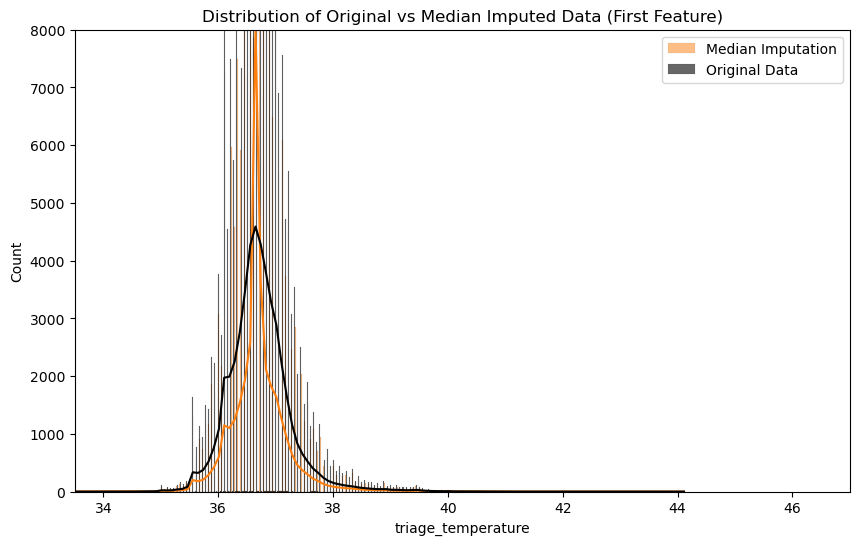

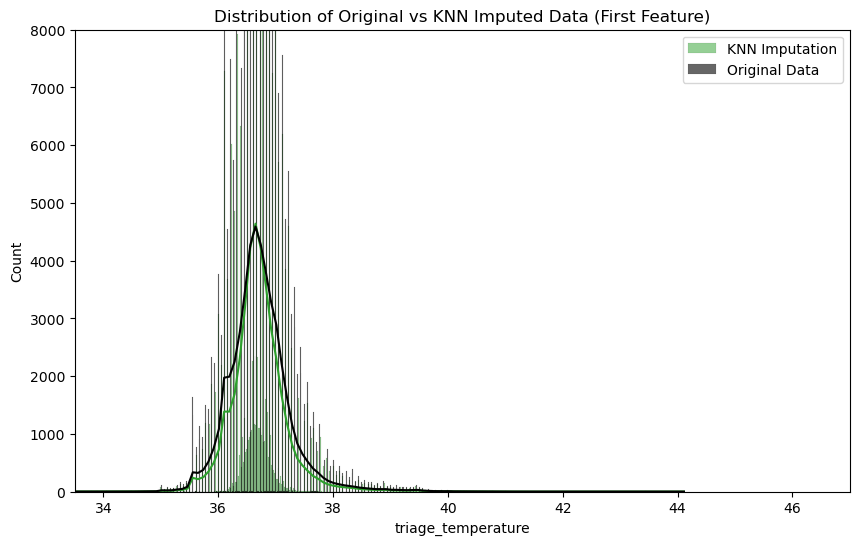

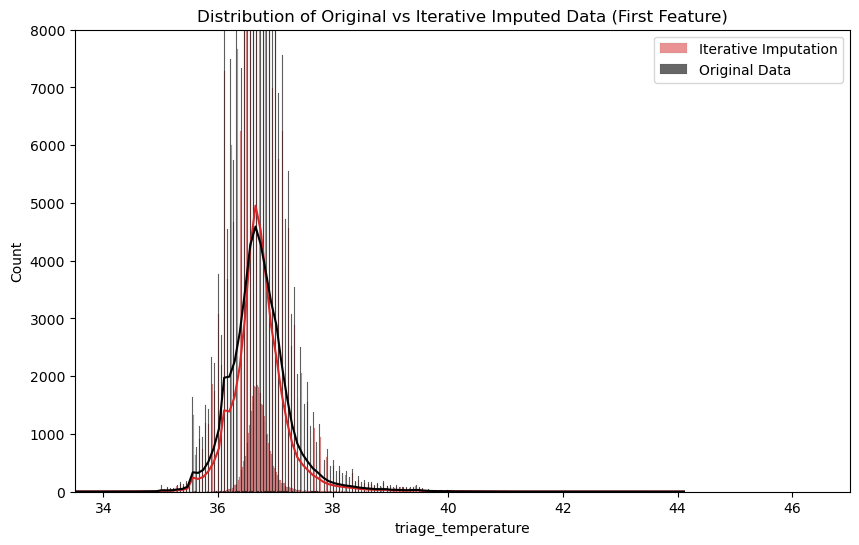

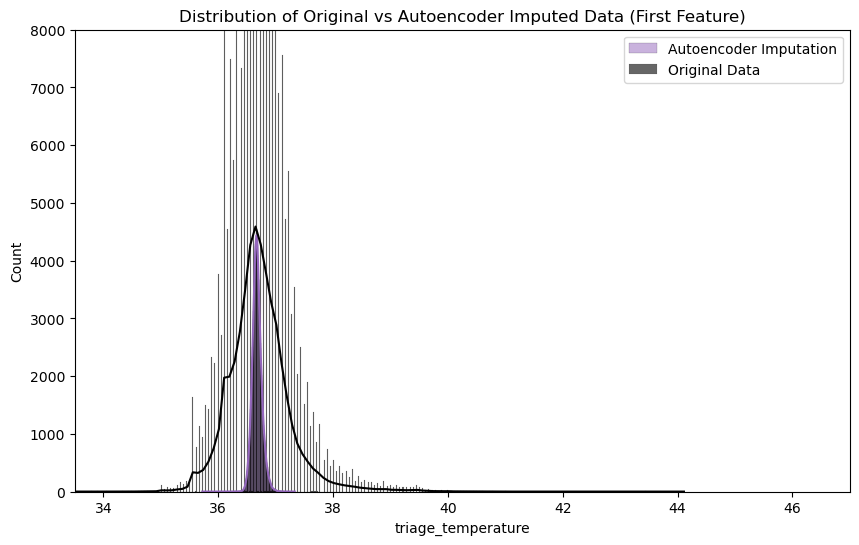

In [32]:
# Optional: Visualize the distribution similarity with seaborn for the last experiment (250,000 samples)
for idx, (method, imputed_data) in enumerate(zip(['Median', 'KNN', 'Iterative', 'Autoencoder'], 
                                                  [df_subset_median_imputed, df_subset_knn_imputed, df_subset_iterative_imputed, df_subset_autoencoded_imputed]), 1):
    plt.figure(figsize=(10, 6))
    sns.histplot(imputed_data.iloc[:, 0], kde=True, label=f"{method} Imputation", color=f"C{idx}")
    sns.histplot(subset.iloc[:, 0], kde=True, label="Original Data", color="black", alpha=0.6)
    plt.xlim(33.5, 47)
    plt.ylim(0, 8000)
    plt.legend()
    plt.title(f"Distribution of Original vs {method} Imputed Data (First Feature)")
    plt.show()


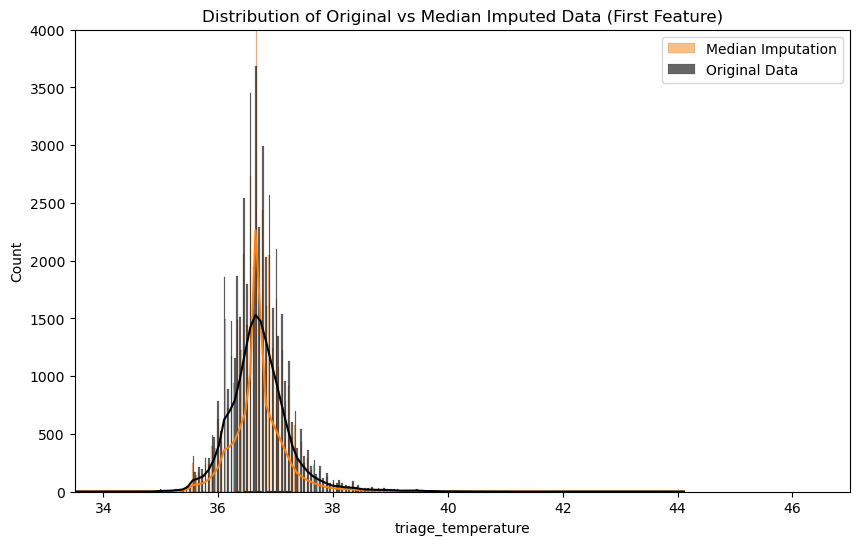

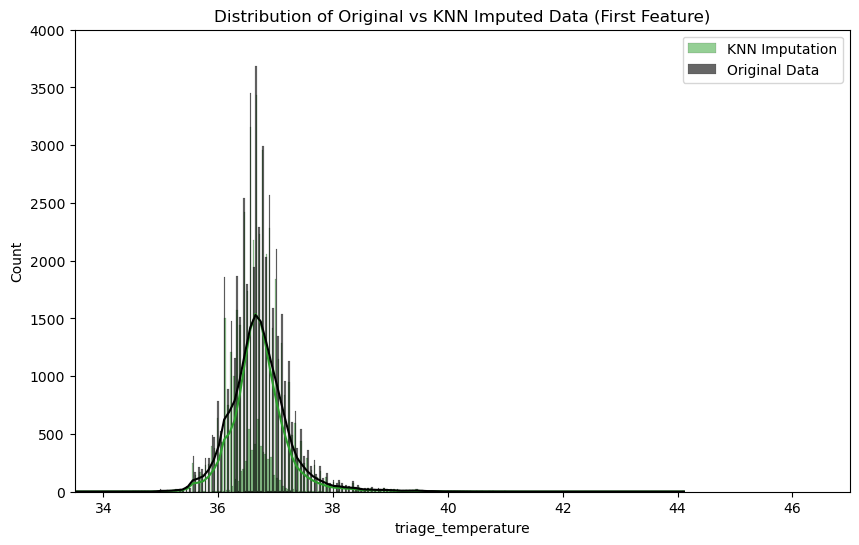

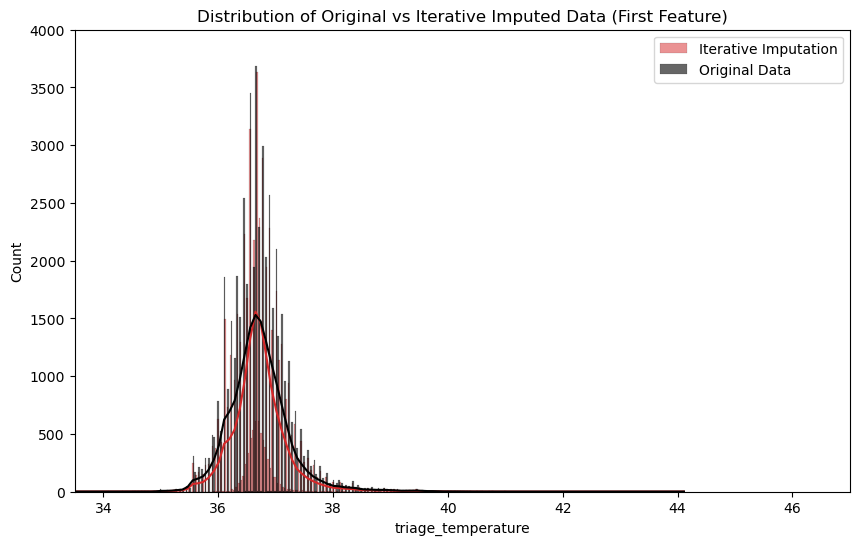

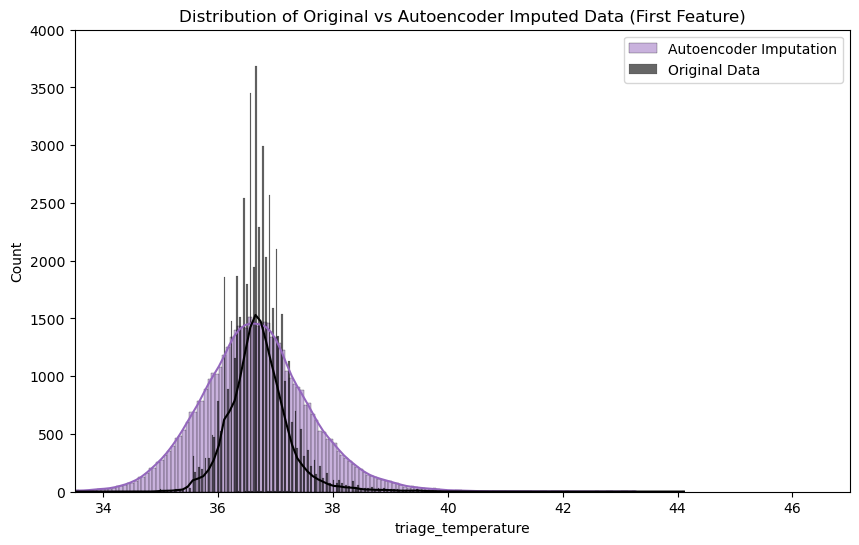

In [27]:
# Optional: Visualize the distribution similarity with seaborn for the last experiment (50,000 samples)
for idx, (method, imputed_data) in enumerate(zip(['Median', 'KNN', 'Iterative', 'Autoencoder'], 
                                                  [df_subset_median_imputed, df_subset_knn_imputed, df_subset_iterative_imputed, df_subset_autoencoded_imputed]), 1):
    plt.figure(figsize=(10, 6))
    sns.histplot(imputed_data.iloc[:, 0], kde=True, label=f"{method} Imputation", color=f"C{idx}")
    sns.histplot(subset.iloc[:, 0], kde=True, label="Original Data", color="black", alpha=0.6)
    plt.xlim(33.5, 47)
    plt.ylim(0, 4000)
    plt.legend()
    plt.title(f"Distribution of Original vs {method} Imputed Data (First Feature)")
    plt.show()



In [37]:
#try another advanced technique LSTM based


import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Model
import warnings

warnings.filterwarnings("ignore")



# Define the valid range for vital signs based on previous analysis
vitals_valid_range = {
    'temperature': {'outlier_low': 14.2, 'valid_low': 26, 'valid_high': 45, 'outlier_high': 47},
    'heartrate': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 350, 'outlier_high': 390},
    'resprate': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 300, 'outlier_high': 330},
    'o2sat': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 100, 'outlier_high': 150},
    'sbp': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 375, 'outlier_high': 375},
    'dbp': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 375, 'outlier_high': 375},
    'pain': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 10, 'outlier_high': 10},
    'acuity': {'outlier_low': 1, 'valid_low': 1, 'valid_high': 5, 'outlier_high': 5}
}

# Filter the columns related to vital signs
vitals_cols = [
    'triage_temperature', 'triage_heartrate', 'triage_resprate',
    'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain', 'triage_acuity',
    'ed_temperature_last', 'ed_heartrate_last', 'ed_resprate_last',
    'ed_o2sat_last', 'ed_sbp_last', 'ed_dbp_last', 'ed_pain_last'
]

# Extract the vital sign data
df_vitals = df_master[vitals_cols]

# Step 1: Remove outliers and impute based on the valid range for each vital sign
def outlier_removal_imputation(column_type, vitals_valid_range):
    column_range = vitals_valid_range[column_type]
    def outlier_removal_imputation_single_value(x):
        if x < column_range['outlier_low'] or x > column_range['outlier_high']:
            # set as missing
            return np.nan
        elif x < column_range['valid_low']:
            # impute with nearest valid value
            return column_range['valid_low']
        elif x > column_range['valid_high']:
            # impute with nearest valid value
            return column_range['valid_high']
        else:
            return x
    return outlier_removal_imputation_single_value

def remove_outliers(df_master, vitals_valid_range):
    df_master = df_master.copy()  # Make a copy to avoid modifying the original DataFrame
    for column in df_master.columns:
        column_type = column.split('_')[1] if len(column.split('_')) > 1 else None
        if column_type in vitals_valid_range:
            df_master[column] = df_master[column].apply(outlier_removal_imputation(column_type, vitals_valid_range))
    return df_master

df_vitals_cleaned = remove_outliers(df_vitals, vitals_valid_range)

# Step 2: Repeat experiment 5 times with larger sample size
num_experiments = 5
sample_size = 250000
all_metrics = []

for i in range(num_experiments):
    print(f"Experiment {i + 1}")
    # Select a larger subset of data without missing values for evaluation
    subset = df_vitals_cleaned.dropna().sample(n=sample_size, random_state=i)

    # Randomly set 20% of the values as missing to create an artificial dataset with missing values
    np.random.seed(i)
    mask = np.random.rand(*subset.shape) < 0.2
    subset_missing = subset.mask(mask)

    # Step 3: LSTM Encoder-Decoder for Imputation
    # Apply PCA to reduce dimensionality after temporarily imputing missing values
    subset_missing_filled = subset_missing.fillna(subset_missing.median())
    pca = PCA(n_components=1)
    subset_pca = pca.fit_transform(subset_missing_filled)

    # Reshape data for LSTM input (samples, timesteps, features)
    subset_pca = subset_pca.reshape((subset_pca.shape[0], 1, 1))
    
    # Define LSTM Encoder-Decoder model
    timesteps = subset_pca.shape[1]
    features = subset_pca.shape[2]
    
    # Use multiple LSTM layers for Encoder and Decoder as depicted in the architecture
    inputs = Input(shape=(timesteps, features))
    encoded = LSTM(50, activation='relu', return_sequences=True)(inputs)
    encoded = LSTM(50, activation='relu')(encoded)
    repeat = RepeatVector(timesteps)(encoded)
    decoded = LSTM(50, activation='relu', return_sequences=True)(repeat)
    decoded = LSTM(50, activation='relu', return_sequences=True)(decoded)
    outputs = TimeDistributed(Dense(features))(decoded)
    lstm_autoencoder = Model(inputs, outputs)
    lstm_autoencoder.compile(optimizer='adam', loss='mse')
    
    # Train LSTM Encoder-Decoder
    lstm_autoencoder.fit(subset_pca, subset_pca, epochs=50, batch_size=32, shuffle=True, verbose=0)
    
    # Use LSTM Encoder-Decoder to impute missing values
    subset_missing_pca = pca.transform(subset_missing_filled)
    subset_missing_pca = subset_missing_pca.reshape((subset_missing_pca.shape[0], 1, 1))
    df_subset_lstm_imputed_pca = lstm_autoencoder.predict(subset_missing_pca).reshape(-1, 1)

    # Inverse transform PCA to get back to original feature space
    df_subset_lstm_imputed = pca.inverse_transform(df_subset_lstm_imputed_pca)

    # Step 4: Evaluation using Metrics (MSE, MAE)
    # Define evaluation function
    def evaluate_imputation(y_true, y_imputed):
        mse = mean_squared_error(y_true, y_imputed)
        mae = mean_absolute_error(y_true, y_imputed)
        return mse, mae

    # Calculate metrics for LSTM imputation
    metrics = {}
    metrics['lstm'] = evaluate_imputation(subset_missing_filled, df_subset_lstm_imputed)

    # Store metrics for this experiment
    all_metrics.append(metrics)

    # Print Performance Comparison for this experiment
    print("Performance Comparison of LSTM Imputation Method:")
    for method, (mse, mae) in metrics.items():
        print(f"{method.capitalize()} Imputer: MSE = {mse:.2f}, MAE = {mae:.2f}")
    print()

# Step 5: Summarize results across all experiments
average_metrics = {}
for method in all_metrics[0].keys():
    mse_values = [metrics[method][0] for metrics in all_metrics]
    mae_values = [metrics[method][1] for metrics in all_metrics]
    average_metrics[method] = (np.mean(mse_values), np.mean(mae_values))

print("Average Performance Comparison of LSTM Imputation Method across 5 Experiments:")
for method, (mse, mae) in average_metrics.items():
    print(f"{method.capitalize()} Imputer: Average MSE = {mse:.2f}, Average MAE = {mae:.2f}")



Experiment 1
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 4s 544us/step
Performance Comparison of LSTM Imputation Method:
Lstm Imputer: MSE = 60.36, MAE = 4.22

Experiment 2
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 5s 563us/step
Performance Comparison of LSTM Imputation Method:
Lstm Imputer: MSE = 60.34, MAE = 4.23

Experiment 3
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 5s 621us/step
Performance Comparison of LSTM Imputation Method:
Lstm Imputer: MSE = 60.40, MAE = 4.23

Experiment 4
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 5s 639us/step
Performance Comparison of LSTM Imputation Method:
Lstm Imputer: MSE = 60.42, MAE = 4.22

Experiment 5
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 4s 483us/step
Performance Comparison of LSTM Imputation Method:
Lstm Imputer: MSE = 60.50, MAE = 4.23

Average Performance Comparison of LSTM Imputation Method across 5 Experiments:
Lstm Imputer: Average MSE = 60.40, Average MAE = 4.22


In [7]:
# advanced technique doesnt give desired results

## ED LOS variable

### Exclusion Criteria

In [24]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# Load the dataset
df_master = pd.read_csv('master_dataset_new.csv')

# Step 1: Remove negative values of ED Length of Stay (ed_los_hours)
# Drop rows with negative LOS values
df_master = df_master[df_master['ed_los_hours'] >= 0]

# Step 2: Drop observations with LOS greater than 24 hours
# Retain only rows where LOS is less than or equal to 24 hours
df_master = df_master[df_master['ed_los_hours'] <= 24]

# Retain only rows where LOS is greater than or equal to 0.5 hours
df_master_impute = df_master_impute[df_master_impute['ed_los_hours'] >= 0.5]
count_after_0_5_hours_filter = len(df_master_impute)
dropped_less_than_0_5 = count_after_24_hours_filter - count_after_0_5_hours_filter
print(f"Number of values dropped for LOS < 0.5 hours: {dropped_less_than_0_5}")



Number of values dropped for LOS < 0.5 hours: 2258


In [25]:
df_master

,index,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,...,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,time_to_microbio_event_hrs,microbiology_event,time_to_med_event_hr,med_event
0,0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,...,98.0,107.0,60.0,0.0,0.0,9.0,10.92,1.0,2.37,1.0
1,1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,...,93.0,96.0,57.0,5.0,3.0,12.0,6.80,1.0,3.33,1.0
2,3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME,...,98.0,81.0,38.0,0.0,2.0,14.0,13.68,1.0,11.53,1.0
3,4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,...,97.0,86.0,45.0,NaN,8.0,14.0,13.68,1.0,1.05,1.0
4,2,10000032,25742920.0,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,F,WHITE,AMBULANCE,ADMITTED,...,99.0,98.0,60.0,NaN,6.0,7.0,23.62,1.0,1.22,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425081,425080,19999784,24935234.0,37972930,2119-07-09 17:38:00,2119-07-10 00:04:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,...,99.0,142.0,80.0,3.0,0.0,1.0,NaN,0.0,0.93,1.0
425082,425081,19999784,25715748.0,34149746,2119-08-11 09:15:00,2119-08-11 13:40:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,...,100.0,131.0,92.0,0.0,1.0,8.0,NaN,0.0,0.48,1.0
425084,425083,19999828,25744818.0,32917002,2149-01-08 09:11:00,2149-01-08 18:12:00,F,WHITE,AMBULANCE,ADMITTED,...,96.0,111.0,78.0,4.0,8.0,11.0,29.12,1.0,0.50,1.0
425085,425085,19999914,NaN,32002659,2158-12-24 11:41:00,2158-12-24 11:56:00,F,UNKNOWN,UNKNOWN,ELOPED,...,100.0,93.0,55.0,0.0,5.0,0.0,NaN,0.0,NaN,0.0


In [26]:
#excluded values
413185-3053

410132

In [29]:
unique_subject_count = df_master['subject_id'].nunique()
print(f"Number of unique subjects: {unique_subject_count}")


Number of unique subjects: 202503


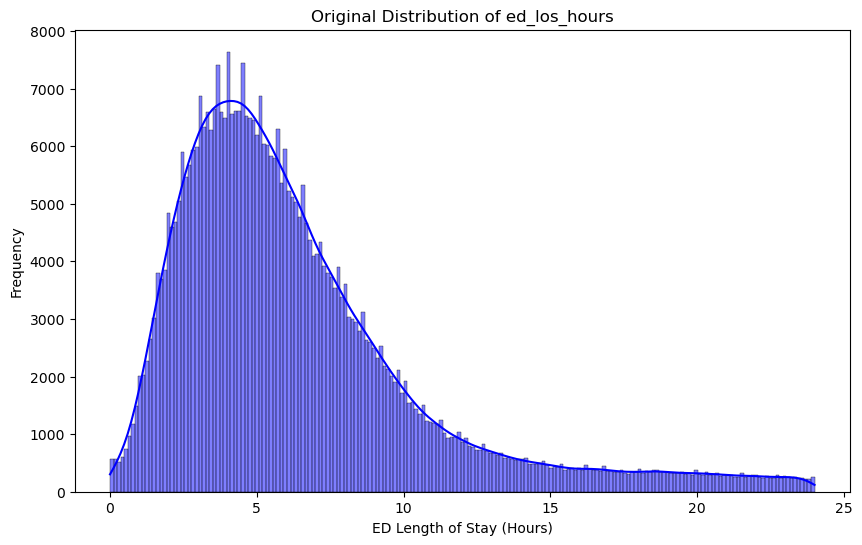

In [19]:
# Plot original distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_master['ed_los_hours'], kde=True, color='blue')
plt.title('Original Distribution of ed_los_hours')
plt.xlabel('ED Length of Stay (Hours)')
plt.ylabel('Frequency')
plt.show()


### Outlier Detection

Number of values dropped for LOS > 24 hours: 0
Number of values dropped for LOS < 0.5 hours: 2258


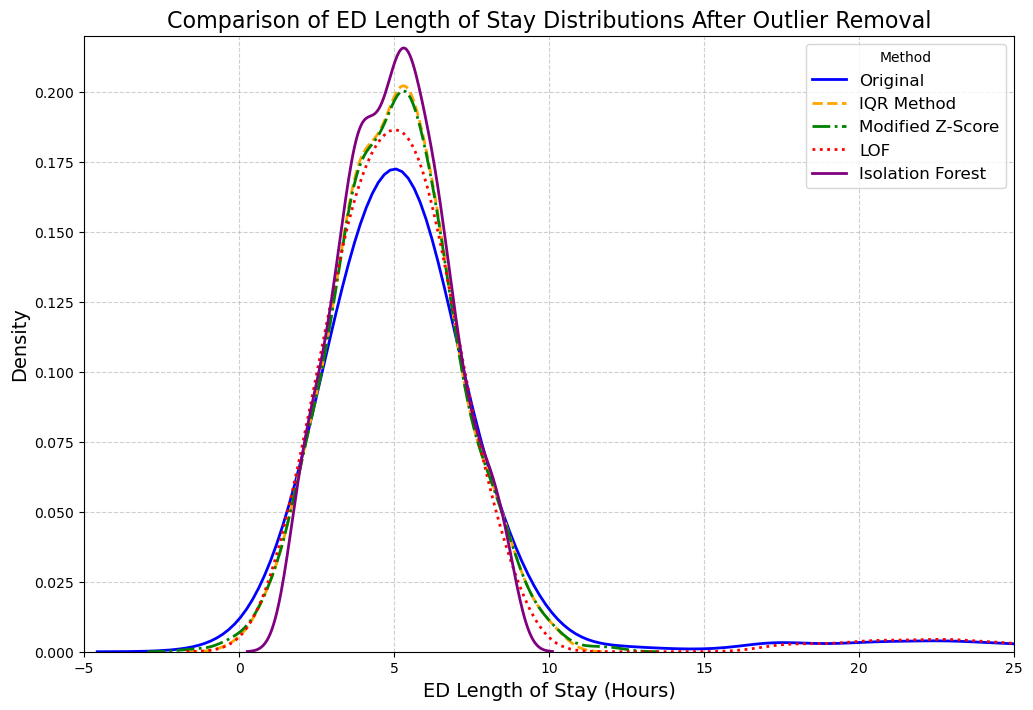

Plot saved as 'ed_los_comparison_outlier_removal.png'


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import scipy.stats as stats

# Sample Data Creation for Demonstration
np.random.seed(42)
ed_los_data = np.random.normal(loc=5, scale=2, size=1000)
ed_los_data = np.concatenate((ed_los_data, np.random.normal(20, 5, size=50)))  # Adding some outliers
df_master = pd.DataFrame({'ed_los_hours': ed_los_data})

# Step 3: Outlier Analysis for ed_los_hours using IQR (Interquartile Range) method
Q1 = df_master['ed_los_hours'].quantile(0.25)
Q3 = df_master['ed_los_hours'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
iqr_outliers = (df_master['ed_los_hours'] < lower_bound) | (df_master['ed_los_hours'] > upper_bound)
df_master['ed_los_hours_iqr'] = np.where(iqr_outliers, np.nan, df_master['ed_los_hours'])

# Step 4: Outlier Analysis for ed_los_hours using Modified Z-Score Method
median = df_master['ed_los_hours'].median()
mad = stats.median_abs_deviation(df_master['ed_los_hours'], nan_policy='omit')
modified_z_scores = 0.6745 * (df_master['ed_los_hours'] - median) / mad
modified_z_outliers = np.abs(modified_z_scores) > 3.5
df_master['ed_los_hours_mz'] = np.where(modified_z_outliers, np.nan, df_master['ed_los_hours'])

# Step 5: Outlier Analysis using Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof_fit = lof.fit_predict(df_master[['ed_los_hours']].dropna().values.reshape(-1, 1))
lof_outliers = lof_fit == -1
df_master['ed_los_hours_lof'] = df_master['ed_los_hours']
df_master.loc[df_master['ed_los_hours'].notna(), 'ed_los_hours_lof'] = np.where(
    lof_outliers,
    np.nan,
    df_master.loc[df_master['ed_los_hours'].notna(), 'ed_los_hours']
)

# Step 6: Outlier Analysis using Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
isolation_fit = iso_forest.fit_predict(df_master[['ed_los_hours']].dropna().values.reshape(-1, 1))
iso_outliers = isolation_fit == -1
df_master['ed_los_hours_iso'] = df_master['ed_los_hours']
df_master.loc[df_master['ed_los_hours'].notna(), 'ed_los_hours_iso'] = np.where(
    iso_outliers,
    np.nan,
    df_master.loc[df_master['ed_los_hours'].notna(), 'ed_los_hours']
)

# Plot all distributions on one plot
plt.figure(figsize=(12, 8))
sns.kdeplot(df_master['ed_los_hours'].dropna(), label='Original', color='blue', linewidth=2)
sns.kdeplot(df_master['ed_los_hours_iqr'].dropna(), label='IQR Method', color='orange', linestyle='--', linewidth=2)
sns.kdeplot(df_master['ed_los_hours_mz'].dropna(), label='Modified Z-Score', color='green', linestyle='-.', linewidth=2)
sns.kdeplot(df_master['ed_los_hours_lof'].dropna(), label='LOF', color='red', linestyle=':', linewidth=2)
sns.kdeplot(df_master['ed_los_hours_iso'].dropna(), label='Isolation Forest', color='purple', linestyle='-', linewidth=2)
plt.title('Comparison of ED Length of Stay Distributions After Outlier Removal', fontsize=16)
plt.xlabel('ED Length of Stay (Hours)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Method', fontsize=12)
plt.xlim(-5, 25)
plt.ylim(0, 0.22)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('outlier_detection.png')
plt.show()
# Save the plot\plt.savefig('ed_los_comparison_outlier_removal.png', dpi=300, bbox_inches='tight')

# Display the path to the saved plot
print("Plot saved as 'ed_los_comparison_outlier_removal.png'")


Number of outliers detected by IQR: 25302


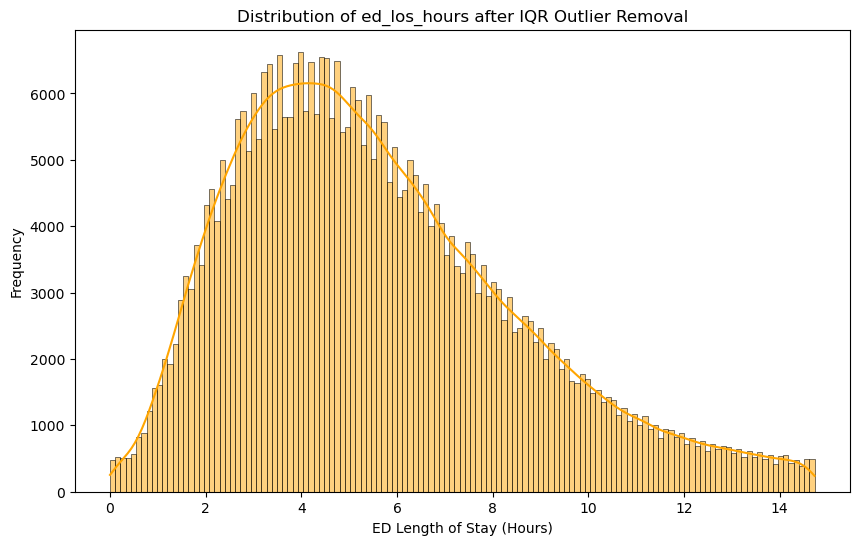

Number of outliers detected by Modified Z-Score: 19462


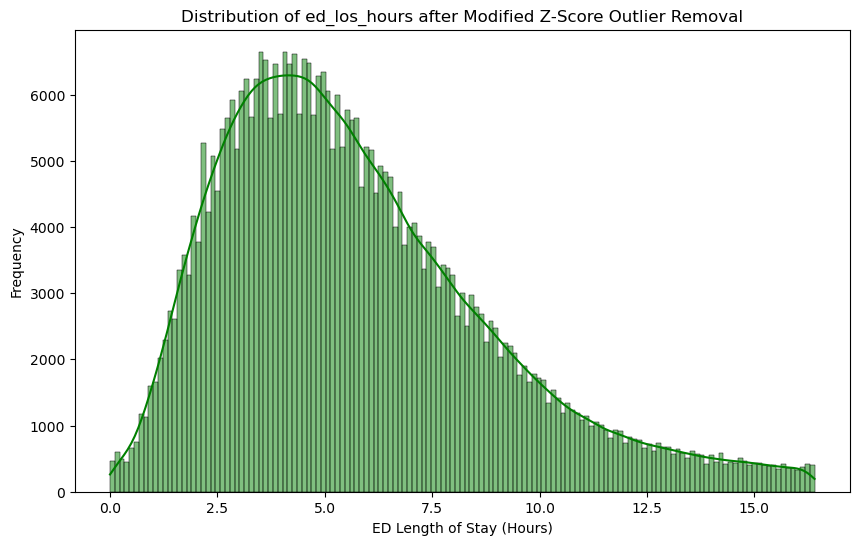

Number of outliers detected by LOF: 3053


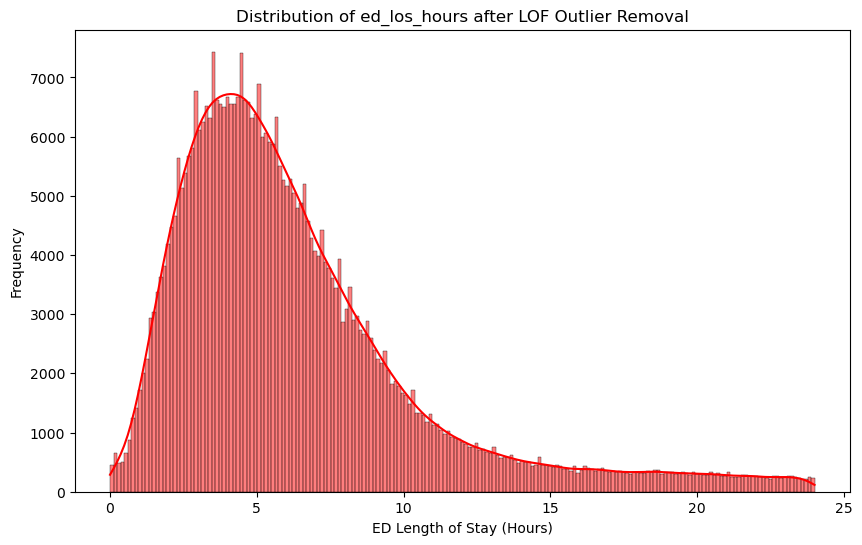

Number of outliers detected by Isolation Forest: 41171


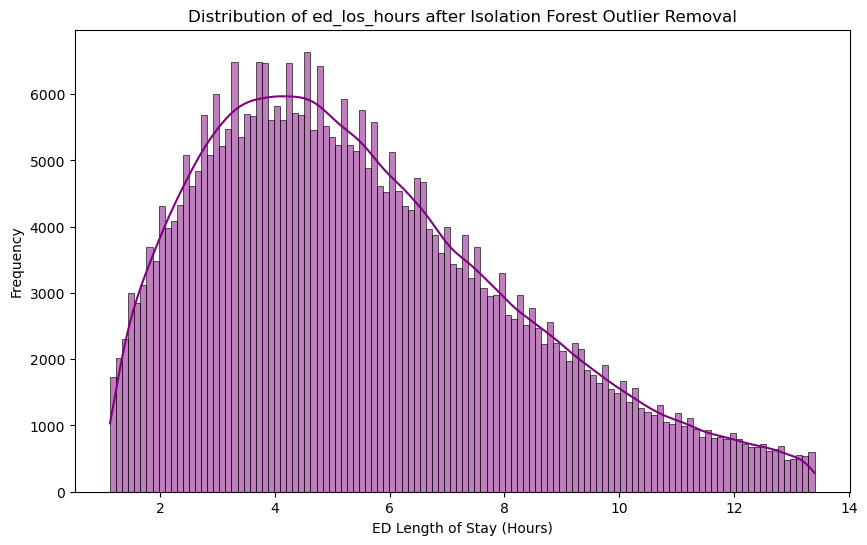

Number of missing values in ed_los_hours after outlier removal: 
ed_los_hours_iqr    25302
ed_los_hours_mz     19462
ed_los_hours_lof     3053
ed_los_hours_iso    41171
dtype: int64

Summary statistics for Original dataset:
count    413185.000000
mean          6.405564
std           4.344248
min           0.000000
25%           3.480000
50%           5.350000
75%           7.980000
max          24.000000
Name: ed_los_hours, dtype: float64

Summary statistics for IQR dataset:
count    387883.000000
mean          5.591215
std           2.969262
min           0.000000
25%           3.370000
50%           5.100000
75%           7.350000
max          14.730000
Name: ed_los_hours_iqr, dtype: float64

Summary statistics for Modified Z-Score dataset:
count    393723.000000
mean          5.738888
std           3.183970
min           0.000000
25%           3.380000
50%           5.150000
75%           7.480000
max          16.400000
Name: ed_los_hours_mz, dtype: float64

Summary statistics for L

In [45]:
# Step 3: Outlier Analysis for ed_los_hours using IQR (Interquartile Range) method
Q1 = df_master['ed_los_hours'].quantile(0.25)
Q3 = df_master['ed_los_hours'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries using IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Mark values outside of these boundaries as NaN (i.e., treat them as missing values)
iqr_outliers = (df_master['ed_los_hours'] < lower_bound) | (df_master['ed_los_hours'] > upper_bound)
df_master['ed_los_hours_iqr'] = np.where(iqr_outliers, np.nan, df_master['ed_los_hours'])

# Count number of outliers detected by IQR
num_iqr_outliers = iqr_outliers.sum()
print(f"Number of outliers detected by IQR: {num_iqr_outliers}")

# Plot distribution after IQR outlier removal
plt.figure(figsize=(10, 6))
sns.histplot(df_master['ed_los_hours_iqr'].dropna(), kde=True, color='orange')
plt.title('Distribution of ed_los_hours after IQR Outlier Removal')
plt.xlabel('ED Length of Stay (Hours)')
plt.ylabel('Frequency')
plt.show()

# Step 4: Outlier Analysis for ed_los_hours using Modified Z-Score Method
median = df_master['ed_los_hours'].median()
mad = stats.median_abs_deviation(df_master['ed_los_hours'], nan_policy='omit')
modified_z_scores = 0.6745 * (df_master['ed_los_hours'] - median) / mad

# Mark values with Modified Z-Score greater than 3.5 as NaN (outliers)
modified_z_outliers = np.abs(modified_z_scores) > 3.5
df_master['ed_los_hours_mz'] = np.where(modified_z_outliers, np.nan, df_master['ed_los_hours'])

# Count number of outliers detected by Modified Z-Score
num_modified_z_outliers = modified_z_outliers.sum()
print(f"Number of outliers detected by Modified Z-Score: {num_modified_z_outliers}")

# Plot distribution after Modified Z-Score outlier removal
plt.figure(figsize=(10, 6))
sns.histplot(df_master['ed_los_hours_mz'].dropna(), kde=True, color='green')
plt.title('Distribution of ed_los_hours after Modified Z-Score Outlier Removal')
plt.xlabel('ED Length of Stay (Hours)')
plt.ylabel('Frequency')
plt.show()

# Step 5: Outlier Analysis using Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof_fit = lof.fit_predict(df_master[['ed_los_hours']].dropna().values.reshape(-1, 1))

# Mark outliers detected by LOF as NaN
lof_outliers = lof_fit == -1
df_master['ed_los_hours_lof'] = df_master['ed_los_hours']
df_master.loc[df_master['ed_los_hours'].notna(), 'ed_los_hours_lof'] = np.where(
    lof_outliers,
    np.nan,
    df_master.loc[df_master['ed_los_hours'].notna(), 'ed_los_hours']
)

# Count number of outliers detected by LOF
num_lof_outliers = np.sum(lof_outliers)
print(f"Number of outliers detected by LOF: {num_lof_outliers}")

# Plot distribution after LOF outlier removal
plt.figure(figsize=(10, 6))
sns.histplot(df_master['ed_los_hours_lof'].dropna(), kde=True, color='red')
plt.title('Distribution of ed_los_hours after LOF Outlier Removal')
plt.xlabel('ED Length of Stay (Hours)')
plt.ylabel('Frequency')
plt.show()

# Step 6: Outlier Analysis using Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
isolation_fit = iso_forest.fit_predict(df_master[['ed_los_hours']].dropna().values.reshape(-1, 1))

# Mark outliers detected by Isolation Forest as NaN
iso_outliers = isolation_fit == -1
df_master['ed_los_hours_iso'] = df_master['ed_los_hours']
df_master.loc[df_master['ed_los_hours'].notna(), 'ed_los_hours_iso'] = np.where(
    iso_outliers,
    np.nan,
    df_master.loc[df_master['ed_los_hours'].notna(), 'ed_los_hours']
)

# Count number of outliers detected by Isolation Forest
num_iso_outliers = np.sum(iso_outliers)
print(f"Number of outliers detected by Isolation Forest: {num_iso_outliers}")

# Plot distribution after Isolation Forest outlier removal
plt.figure(figsize=(10, 6))
sns.histplot(df_master['ed_los_hours_iso'].dropna(), kde=True, color='purple')
plt.title('Distribution of ed_los_hours after Isolation Forest Outlier Removal')
plt.xlabel('ED Length of Stay (Hours)')
plt.ylabel('Frequency')
plt.show()

# Display summary of missing values
df_missing_summary = df_master[['ed_los_hours_iqr', 'ed_los_hours_mz', 'ed_los_hours_lof', 'ed_los_hours_iso']].isna().sum()
print(f"Number of missing values in ed_los_hours after outlier removal: \n{df_missing_summary}")

# Compare summary statistics before and after outlier removal
methods = ['Original', 'IQR', 'Modified Z-Score', 'LOF', 'Isolation Forest']
datasets = [df_master['ed_los_hours'], df_master['ed_los_hours_iqr'], df_master['ed_los_hours_mz'], df_master['ed_los_hours_lof'], df_master['ed_los_hours_iso']]

for method, data in zip(methods, datasets):
    print(f"\nSummary statistics for {method} dataset:")
    print(data.describe())


In [46]:
#minimize the loss of data (lowest number of outliers) and preserve the original data distribution, LOF seems to be the best choice.

In [52]:
df_master_lof

,index,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,...,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,time_to_microbio_event_hrs,microbiology_event,time_to_med_event_hr,med_event
0,0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,...,98.0,107.0,60.0,0.0,0.0,9.0,10.92,1.0,2.37,1.0
1,1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,...,93.0,96.0,57.0,5.0,3.0,12.0,6.80,1.0,3.33,1.0
2,3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME,...,98.0,81.0,38.0,0.0,2.0,14.0,13.68,1.0,11.53,1.0
3,4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,...,97.0,86.0,45.0,NaN,8.0,14.0,13.68,1.0,1.05,1.0
4,2,10000032,25742920.0,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,F,WHITE,AMBULANCE,ADMITTED,...,99.0,98.0,60.0,NaN,6.0,7.0,23.62,1.0,1.22,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425081,425080,19999784,24935234.0,37972930,2119-07-09 17:38:00,2119-07-10 00:04:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,...,99.0,142.0,80.0,3.0,0.0,1.0,NaN,0.0,0.93,1.0
425082,425081,19999784,25715748.0,34149746,2119-08-11 09:15:00,2119-08-11 13:40:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,...,100.0,131.0,92.0,0.0,1.0,8.0,NaN,0.0,0.48,1.0
425084,425083,19999828,25744818.0,32917002,2149-01-08 09:11:00,2149-01-08 18:12:00,F,WHITE,AMBULANCE,ADMITTED,...,96.0,111.0,78.0,4.0,8.0,11.0,29.12,1.0,0.50,1.0
425085,425085,19999914,NaN,32002659,2158-12-24 11:41:00,2158-12-24 11:56:00,F,UNKNOWN,UNKNOWN,ELOPED,...,100.0,93.0,55.0,0.0,5.0,0.0,NaN,0.0,NaN,0.0


In [50]:
# Drop rows with negative LOS values
df_master_lof = df_master.copy()

### Handle missing values for ed los with different imputation methods


2024-10-30 22:26:12.417489: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 22:26:12.425897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 22:26:12.434886: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 22:26:12.437525: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 22:26:12.444235: I tensorflow/core/platform/cpu_feature_guar

Experiment 1
Epoch 1/10


I0000 00:00:1730319985.161843   53069 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-30 22:26:25.187018: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/cstylianides/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 180/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - loss: 0.0545

2024-10-30 22:26:26.287146: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0143
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 966us/step - loss: 3.2422e-06
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 951us/step - loss: 9.9751e-07
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.0322e-07
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.0189e-07
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.5388e-07
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.9040e-07
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.1836e-07
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - loss: 4.1584e-07
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.4408e-07
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 436us/step
Performance Comparison of Imputation Methods:
Median Imputer: MSE = 4.04, MAE = 0.62
Knn Imputer: MSE = 3.81, MAE = 0.64
Iterative Imputer: MSE = 3.81, MAE = 0.64
Autoencoder Imputer: MSE = 12.17, MAE = 1.31

Experiment 2
Epoch 1/10


/home/cstylianides/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0169
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.4898e-06
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - loss: 1.8387e-06
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3718e-06
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.2381e-06
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3157e-06
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 927us/step - loss: 9.5076e-07
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8.1789e-07
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9.8782e-07
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.9279e-07
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 621us/step
Performance Comparison of Imputation Methods:
Median Imputer: MSE = 3.91, MAE = 0.60
Knn Imputer: MSE = 3.68, MAE = 0.63
Iterative Imputer: MSE = 3.68, MAE = 0.63
Autoencoder Imputer: MSE = 11.96, MAE = 1.31

Experiment 3
Epoch 1/10


/home/cstylianides/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 945us/step - loss: 0.0140
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.5765e-06
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.3725e-07
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.3855e-07
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 997us/step - loss: 2.7193e-07
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 999us/step - loss: 2.7579e-07
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step - loss: 2.8479e-07
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.9229e-07
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.3964e-07
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 7.5575e-07
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 413us/step
Performance Comparison of Imputation Methods:
Median Imputer: MSE = 3.97, MAE = 0.61
Knn Imputer: MSE = 3.75, MAE = 0.63
Iterative Imputer: MSE = 3.75, MAE = 0.63
Autoencoder Imputer: MSE = 12.07, MAE = 1.29

Experiment 4
Epoch 1/1

/home/cstylianides/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0152
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.4681e-06
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.9586e-07
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3908e-07
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.1851e-07
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.5208e-07
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.2931e-07
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.2890e-07
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 950us/step - loss: 5.1898e-07
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.7037e-07
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step
Performance Comparison of Imputation Methods:
Median Imputer: MSE = 4.00, MAE = 0.61
Knn Imputer: MSE = 3.78, MAE = 0.63
Iterative Imputer: MSE = 3.78, MAE = 0.63
Autoencoder Imputer: MSE = 12.13, MAE = 1.30

Experiment 5
Epoch 1/10


/home/cstylianides/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 989us/step - loss: 0.0170
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.6462e-06
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.1112e-07
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.4138e-07
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.2026e-07
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.3526e-07
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.3875e-07
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.7792e-07
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 978us/step - loss: 3.5610e-07
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.5086e-07
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step
Performance Comparison of Imputation Methods:
Median Imputer: MSE = 4.09, MAE = 0.62
Knn Imputer: MSE = 3.86, MAE = 0.65
Iterative Imputer: MSE = 3.86, MAE = 0.65
Autoencoder Imputer: MSE = 12.28, MAE = 1.31

Average Performance Compar

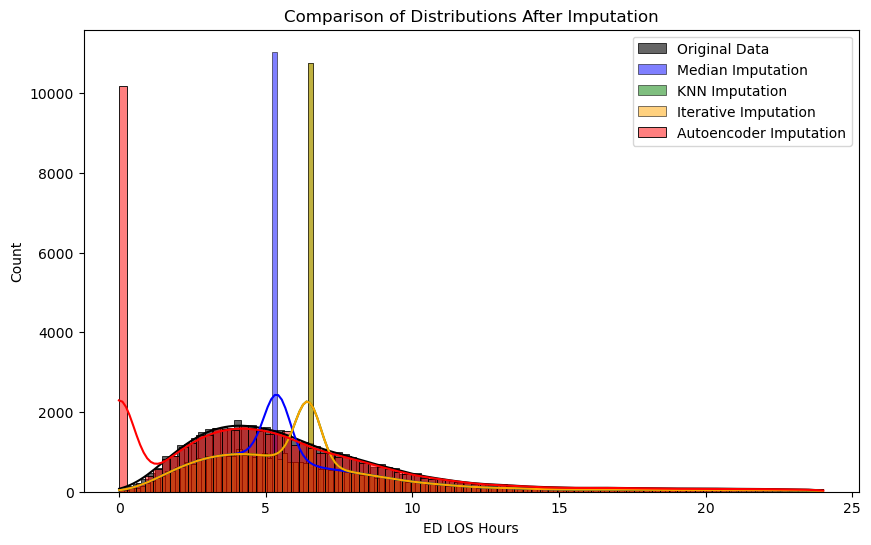

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from keras.models import Sequential
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df_master = pd.read_csv('master_dataset_new.csv')

# Step 1: Remove negative values of ED Length of Stay (ed_los_hours)
# Drop rows with negative LOS values
df_master_impute = df_master.copy()
df_master_impute = df_master_impute[df_master_impute['ed_los_hours'] >= 0]

# Step 2: Drop observations with LOS greater than 24 hours
# Retain only rows where LOS is less than or equal to 24 hours
df_master_impute = df_master_impute[df_master_impute['ed_los_hours'] <= 24]

# Encode categorical variables
label_encoders = {}
for col in ['gender', 'race', 'arrival_transport', 'disposition']:
    le = LabelEncoder()
    df_master_impute[col] = le.fit_transform(df_master_impute[col].astype(str))
    label_encoders[col] = le

# Select relevant variables for imputation
relevant_columns = ['ed_los_hours', 'age', 'triage_temperature', 'triage_heartrate', 'triage_resprate', 
                    'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain', 'gender', 'race', 
                    'arrival_transport', 'disposition', 'n_ed_30d', 'n_ed_90d',
                   'n_ed_365d', 'chiefcom_chest_pain', 'chiefcom_abdominal_pain', 
                    'chiefcom_headache', 'chiefcom_shortness_of_breath', 'chiefcom_back_pain', 'chiefcom_cough', 
                    'chiefcom_nausea_vomiting', 'chiefcom_fever_chills', 'chiefcom_syncope', 'chiefcom_dizziness', 
                    'cci_MI', 'cci_CHF', 'cci_PVD', 'cci_Stroke', 'cci_Dementia', 'cci_Pulmonary', 'cci_Rheumatic', 
                    'cci_PUD', 'cci_Liver1', 'cci_DM1', 'cci_DM2']
df_master_impute = df_master_impute[relevant_columns]

# Step 3: Repeat experiment for 5 times with a sample size of 50,000
num_experiments = 5
sample_size = 50000
all_metrics = []

for i in range(num_experiments):
    print(f"Experiment {i + 1}")
    # Select a large subset of data without missing values for evaluation
    subset = df_master_impute.dropna().sample(n=min(sample_size, len(df_master_impute.dropna())), random_state=i)

    # Randomly set 20% of the ed_los_hours values as missing to create an artificial dataset with missing values
    np.random.seed(i)
    mask = np.random.rand(len(subset)) < 0.2
    subset_missing = subset.copy()
    subset_missing.loc[mask, 'ed_los_hours'] = np.nan

    # Step 4: Handle missing values for ed_los_hours with different imputation methods
    # Median Imputer
    median_imputer = SimpleImputer(strategy='median')
    df_subset_median_imputed = subset_missing.copy()
    df_subset_median_imputed['ed_los_hours'] = median_imputer.fit_transform(subset_missing[['ed_los_hours']])

    # KNN Imputer
    knn_imputer = KNNImputer(n_neighbors=5)
    df_subset_knn_imputed = subset_missing.copy()
    df_subset_knn_imputed['ed_los_hours'] = knn_imputer.fit_transform(subset_missing[['ed_los_hours']])

    # Iterative Imputer
    iterative_imputer = IterativeImputer(random_state=0)
    df_subset_iterative_imputed = subset_missing.copy()
    df_subset_iterative_imputed['ed_los_hours'] = iterative_imputer.fit_transform(subset_missing[['ed_los_hours']])

    # Autoencoder Imputer
    scaler = MinMaxScaler()
    ed_los_scaled = scaler.fit_transform(subset_missing[['ed_los_hours']].fillna(0))
    
    # Reshape data for LSTM input (samples, timesteps, features)
    ed_los_scaled = ed_los_scaled.reshape((ed_los_scaled.shape[0], 1, ed_los_scaled.shape[1]))

    # Define LSTM Autoencoder model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
    model.add(RepeatVector(1))
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(ed_los_scaled, ed_los_scaled, epochs=10, batch_size=32, verbose=1)

    # Predict missing values
    ed_los_pred = model.predict(ed_los_scaled)
    ed_los_imputed = scaler.inverse_transform(ed_los_pred.reshape(-1, 1))
    df_subset_autoencoded_imputed = subset_missing.copy()
    df_subset_autoencoded_imputed['ed_los_hours'] = ed_los_imputed

    # Step 5: Evaluation using Metrics (RMSE, MAE)
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    # Define evaluation function
    def evaluate_imputation(y_true, y_imputed):
        mse = mean_squared_error(y_true, y_imputed)
        mae = mean_absolute_error(y_true, y_imputed)
        return mse, mae

    # Calculate metrics for each imputation technique
    metrics = {}
    metrics['median'] = evaluate_imputation(subset['ed_los_hours'], df_subset_median_imputed['ed_los_hours'])
    metrics['knn'] = evaluate_imputation(subset['ed_los_hours'], df_subset_knn_imputed['ed_los_hours'])
    metrics['iterative'] = evaluate_imputation(subset['ed_los_hours'], df_subset_iterative_imputed['ed_los_hours'])
    metrics['autoencoder'] = evaluate_imputation(subset['ed_los_hours'], df_subset_autoencoded_imputed['ed_los_hours'])

    # Store metrics for this experiment
    all_metrics.append(metrics)

    # Print Performance Comparison for this experiment
    print("Performance Comparison of Imputation Methods:")
    for method, (mse, mae) in metrics.items():
        print(f"{method.capitalize()} Imputer: MSE = {mse:.2f}, MAE = {mae:.2f}")
    print()

# Step 6: Summarize results across all experiments
average_metrics = {}
for method in all_metrics[0].keys():
    mse_values = [metrics[method][0] for metrics in all_metrics]
    mae_values = [metrics[method][1] for metrics in all_metrics]
    average_metrics[method] = (np.mean(mse_values), np.mean(mae_values))

print("Average Performance Comparison of Imputation Methods across 5 Experiments:")
for method, (mse, mae) in average_metrics.items():
    print(f"{method.capitalize()} Imputer: Average MSE = {mse:.2f}, Average MAE = {mae:.2f}")

# Step 7: Visualize the distribution similarity with seaborn
plt.figure(figsize=(10, 6))
sns.histplot(subset['ed_los_hours'], kde=True, color='black', label='Original Data', alpha=0.6)
sns.histplot(df_subset_median_imputed['ed_los_hours'], kde=True, label='Median Imputation', color='blue')
sns.histplot(df_subset_knn_imputed['ed_los_hours'], kde=True, label='KNN Imputation', color='green')
sns.histplot(df_subset_iterative_imputed['ed_los_hours'], kde=True, label='Iterative Imputation', color='orange')
sns.histplot(df_subset_autoencoded_imputed['ed_los_hours'], kde=True, label='Autoencoder Imputation', color='red')
plt.legend()
plt.xlabel('ED LOS Hours')
plt.title('Comparison of Distributions After Imputation')
plt.show()



In [6]:
#df_master

Experiment 1
Epoch 1/10


/home/cstylianides/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7813/7813 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0047
Epoch 2/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 3.3059e-07
Epoch 3/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 3.1864e-07
Epoch 4/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.8044e-07
Epoch 5/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.9919e-07
Epoch 6/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.5299e-07
Epoch 7/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.4505e-07
Epoch 8/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.9838e-07
Epoch 9/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 1.9454e-07
Epoch 10/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.0954e-07
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 3s 370us/step
Performance Comparison of Imputation Methods:
Median Imputer: MSE = 4.03, MAE = 0.61
Knn Imputer: MSE = 3.80, MAE = 0.64
Iterative Imputer: MSE = 3.80, MAE = 0.64
Autoencoder Imputer: MSE = 12.16, MAE = 1.30

Experiment 2
Epoch 1/10


/home/cstylianides/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7813/7813 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.0045
Epoch 2/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 3.6633e-07
Epoch 3/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.2967e-07
Epoch 4/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 1.6615e-07
Epoch 5/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 1.5005e-07
Epoch 6/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 1.6762e-07
Epoch 7/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 1.3054e-07
Epoch 8/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 1.1445e-07
Epoch 9/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 1.2807e-07
Epoch 10/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 1.2441e-07
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 3s 368us/step
Performance Comparison of Imputation Methods:
Median Imputer: MSE = 4.00, MAE = 0.61
Knn Imputer: MSE = 3.77, MAE = 0.63
Iterative Imputer: MSE = 3.77, MAE = 0.63
Autoencoder Imputer: MSE = 12.08, MAE = 1.30

Experiment 3
Epoch 1/10


/home/cstylianides/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7813/7813 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0045
Epoch 2/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 3.2681e-07
Epoch 3/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.9121e-07
Epoch 4/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.5006e-07
Epoch 5/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 2.1835e-07
Epoch 6/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 1.7979e-07
Epoch 7/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 1.7374e-07
Epoch 8/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.4715e-07
Epoch 9/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 1.6458e-07
Epoch 10/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 1.6028e-07
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 3s 426us/step
Performance Comparison of Imputation Methods:
Median Imputer: MSE = 4.08, MAE = 0.61
Knn Imputer: MSE = 3.84, MAE = 0.64
Iterative Imputer: MSE = 3.84, MAE = 0.64
Autoencoder Imputer: MSE = 12.24, MAE = 1.31

Experiment 4
Epoch 1/10


/home/cstylianides/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.0040
Epoch 2/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 2.7547e-07
Epoch 3/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.2605e-07
Epoch 4/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.2078e-07
Epoch 5/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 1.9569e-07
Epoch 6/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 1.8947e-07
Epoch 7/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 1.9307e-07
Epoch 8/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.9582e-07
Epoch 9/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.0952e-07
Epoch 10/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.1716e-07
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 3s 372us/step
Performance Comparison of Imputation Methods:
Median Imputer: MSE = 4.02, MAE = 0.61
Knn Imputer: MSE = 3.79, MAE = 0.63
Iterative Imputer: MSE = 3.79, MAE = 0.63
Autoencoder Imputer: MSE = 12.10, MAE = 1.30

Experiment 5
Epoch 1/10


/home/cstylianides/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7813/7813 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0040
Epoch 2/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 3.0951e-07
Epoch 3/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 2.5721e-07
Epoch 4/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.4346e-07
Epoch 5/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 2.1890e-07
Epoch 6/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.3110e-07
Epoch 7/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.1212e-07
Epoch 8/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 2.1148e-07
Epoch 9/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 1.6166e-07
Epoch 10/10
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 1.7970e-07
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 3s 401us/step
Performance Comparison of Imputation Methods:
Median Imputer: MSE = 4.09, MAE = 0.62
Knn Imputer: MSE = 3.86, MAE = 0.64
Iterative Imputer: MSE = 3.86, MAE = 0.64
Autoencoder Imputer: MSE = 12.31, MAE = 1.31

Average Performance Compa

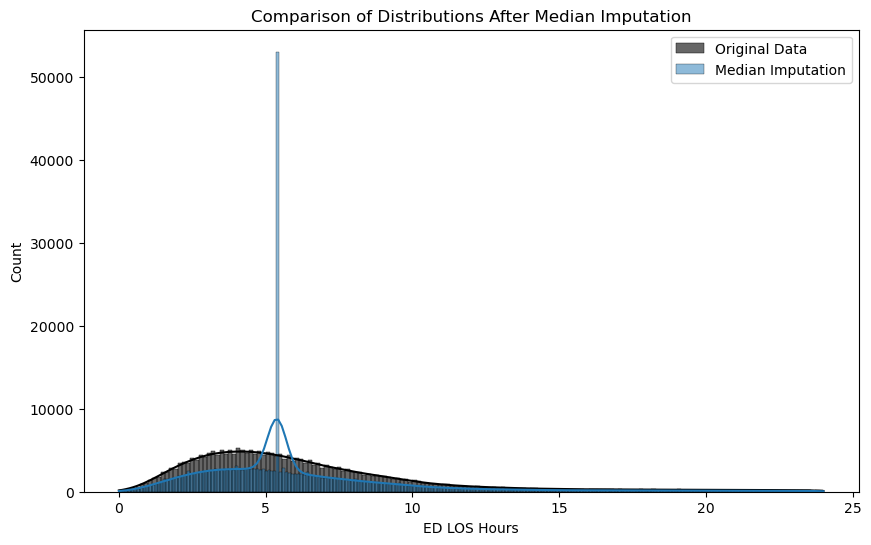

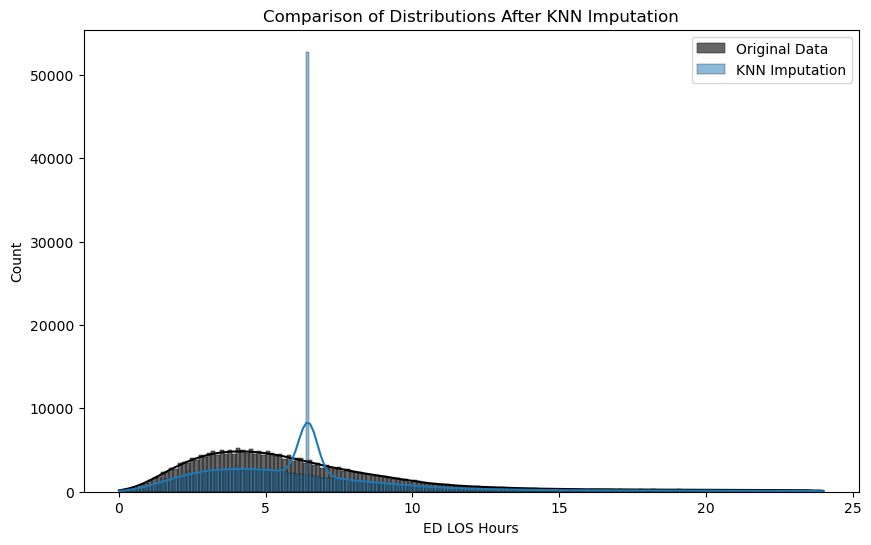

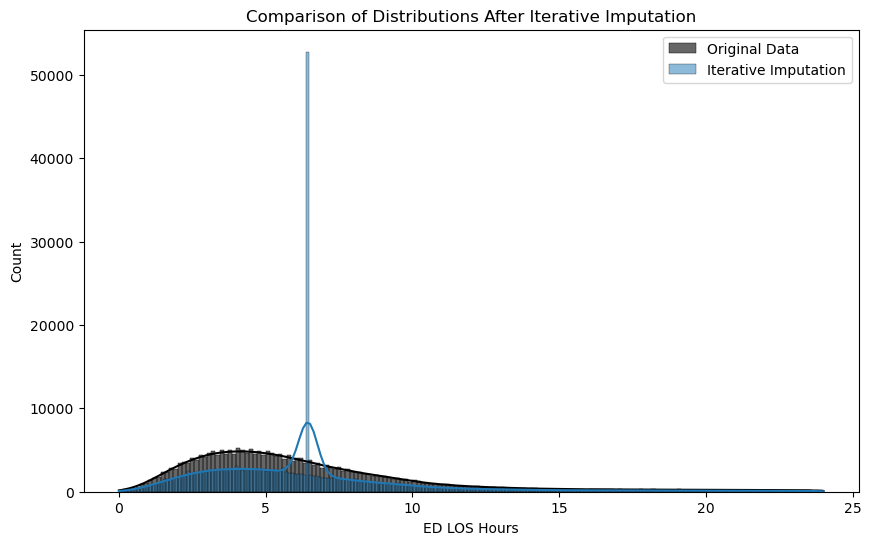

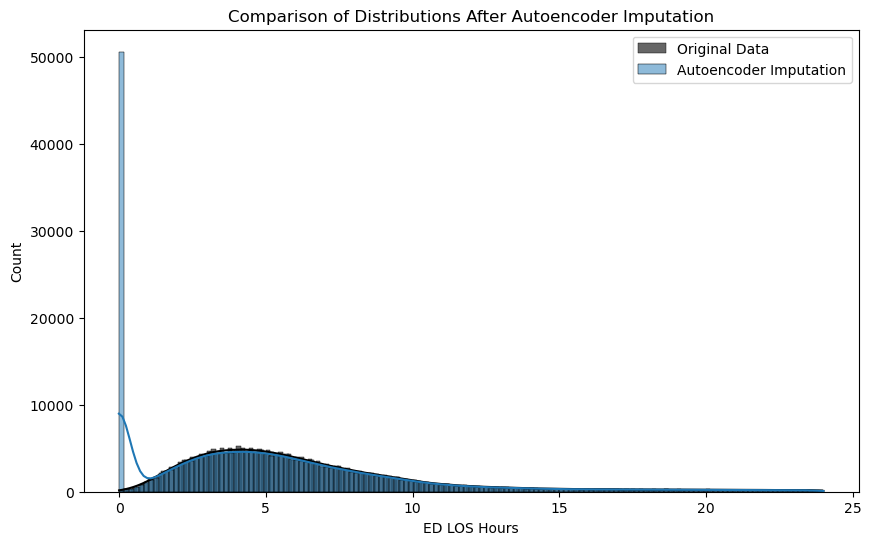

In [2]:
#repeat 250000 times

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from keras.models import Sequential
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df_master = pd.read_csv('master_dataset_new.csv')

# Step 1: Remove negative values of ED Length of Stay (ed_los_hours)
# Drop rows with negative LOS values
df_master_impute = df_master.copy()
df_master_impute = df_master_impute[df_master_impute['ed_los_hours'] >= 0]

# Step 2: Drop observations with LOS greater than 24 hours
# Retain only rows where LOS is less than or equal to 24 hours
df_master_impute = df_master_impute[df_master_impute['ed_los_hours'] <= 24]

# Encode categorical variables
label_encoders = {}
for col in ['gender', 'race', 'arrival_transport', 'disposition']:
    le = LabelEncoder()
    df_master_impute[col] = le.fit_transform(df_master_impute[col].astype(str))
    label_encoders[col] = le

# Select relevant variables for imputation
relevant_columns = ['ed_los_hours', 'age', 'triage_temperature', 'triage_heartrate', 
                    'triage_resprate', 'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain',
                    'gender', 'race', 'arrival_transport', 'disposition', 'n_ed_30d', 'n_ed_90d', 
                    'n_ed_365d', 'chiefcom_chest_pain', 'chiefcom_abdominal_pain', 'chiefcom_headache', 
                    'chiefcom_shortness_of_breath', 'chiefcom_back_pain', 'chiefcom_cough', 
                    'chiefcom_nausea_vomiting', 'chiefcom_fever_chills', 'chiefcom_syncope', 
                    'chiefcom_dizziness', 'cci_MI', 'cci_CHF', 'cci_PVD', 'cci_Stroke', 'cci_Dementia', 
                    'cci_Pulmonary', 'cci_Rheumatic', 'cci_PUD', 'cci_Liver1', 'cci_DM1', 'cci_DM2']
df_master_impute = df_master_impute[relevant_columns]

# Step 3: Repeat experiment for 5 times with a sample size of 250,000
num_experiments = 5
sample_size = 250000
all_metrics = []

for i in range(num_experiments):
    print(f"Experiment {i + 1}")
    # Select a large subset of data without missing values for evaluation
    subset = df_master_impute.dropna().sample(n=min(sample_size, len(df_master_impute.dropna())), random_state=i)

    # Randomly set 20% of the ed_los_hours values as missing to create an artificial dataset with missing values
    np.random.seed(i)
    mask = np.random.rand(len(subset)) < 0.2
    subset_missing = subset.copy()
    subset_missing.loc[mask, 'ed_los_hours'] = np.nan

    # Step 4: Handle missing values for ed_los_hours with different imputation methods
    # Median Imputer
    median_imputer = SimpleImputer(strategy='median')
    df_subset_median_imputed = subset_missing.copy()
    df_subset_median_imputed['ed_los_hours'] = median_imputer.fit_transform(subset_missing[['ed_los_hours']])

    # KNN Imputer
    knn_imputer = KNNImputer(n_neighbors=5)
    df_subset_knn_imputed = subset_missing.copy()
    df_subset_knn_imputed['ed_los_hours'] = knn_imputer.fit_transform(subset_missing[['ed_los_hours']])

    # Iterative Imputer
    iterative_imputer = IterativeImputer(random_state=0)
    df_subset_iterative_imputed = subset_missing.copy()
    df_subset_iterative_imputed['ed_los_hours'] = iterative_imputer.fit_transform(subset_missing[['ed_los_hours']])

    # Autoencoder Imputer
    scaler = MinMaxScaler()
    ed_los_scaled = scaler.fit_transform(subset_missing[['ed_los_hours']].fillna(0))
    
    # Reshape data for LSTM input (samples, timesteps, features)
    ed_los_scaled = ed_los_scaled.reshape((ed_los_scaled.shape[0], 1, ed_los_scaled.shape[1]))

    # Define LSTM Autoencoder model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
    model.add(RepeatVector(1))
    model.add(LSTM(50, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(ed_los_scaled, ed_los_scaled, epochs=10, batch_size=32, verbose=1)

    # Predict missing values
    ed_los_pred = model.predict(ed_los_scaled)
    ed_los_imputed = scaler.inverse_transform(ed_los_pred.reshape(-1, 1))
    df_subset_autoencoded_imputed = subset_missing.copy()
    df_subset_autoencoded_imputed['ed_los_hours'] = ed_los_imputed

    # Step 5: Evaluation using Metrics (RMSE, MAE)
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    # Define evaluation function
    def evaluate_imputation(y_true, y_imputed):
        mse = mean_squared_error(y_true, y_imputed)
        mae = mean_absolute_error(y_true, y_imputed)
        return mse, mae

    # Calculate metrics for each imputation technique
    metrics = {}
    metrics['median'] = evaluate_imputation(subset['ed_los_hours'], df_subset_median_imputed['ed_los_hours'])
    metrics['knn'] = evaluate_imputation(subset['ed_los_hours'], df_subset_knn_imputed['ed_los_hours'])
    metrics['iterative'] = evaluate_imputation(subset['ed_los_hours'], df_subset_iterative_imputed['ed_los_hours'])
    metrics['autoencoder'] = evaluate_imputation(subset['ed_los_hours'], df_subset_autoencoded_imputed['ed_los_hours'])

    # Store metrics for this experiment
    all_metrics.append(metrics)

    # Print Performance Comparison for this experiment
    print("Performance Comparison of Imputation Methods:")
    for method, (mse, mae) in metrics.items():
        print(f"{method.capitalize()} Imputer: MSE = {mse:.2f}, MAE = {mae:.2f}")
    print()

# Step 6: Summarize results across all experiments
average_metrics = {}
for method in all_metrics[0].keys():
    mse_values = [metrics[method][0] for metrics in all_metrics]
    mae_values = [metrics[method][1] for metrics in all_metrics]
    average_metrics[method] = (np.mean(mse_values), np.mean(mae_values))

print("Average Performance Comparison of Imputation Methods across 5 Experiments:")
for method, (mse, mae) in average_metrics.items():
    print(f"{method.capitalize()} Imputer: Average MSE = {mse:.2f}, Average MAE = {mae:.2f}")

# Step 7: Visualize the distribution similarity with seaborn
for method, imputed_df in zip(['Median', 'KNN', 'Iterative', 'Autoencoder'], [df_subset_median_imputed, df_subset_knn_imputed, df_subset_iterative_imputed, df_subset_autoencoded_imputed]):
    plt.figure(figsize=(10, 6))
    sns.histplot(subset['ed_los_hours'], kde=True, color='black', label='Original Data', alpha=0.6)
    sns.histplot(imputed_df['ed_los_hours'], kde=True, label=f'{method} Imputation')
    plt.legend()
    plt.xlabel('ED LOS Hours')
    plt.title(f'Comparison of Distributions After {method} Imputation')
    plt.show()
